In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, MaxPool2D, Dense, Flatten, Dropout, GlobalAveragePooling2D, Input, Bidirectional, LSTM, TimeDistributed, RNN, BatchNormalization
from tensorflow.keras import callbacks 
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, LearningRateScheduler
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.applications.xception import Xception
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import KFold
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.utils import shuffle
from tqdm import tqdm
import itertools
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import pandas as pd
import numpy as np
import shutil
import cv2
import os

print ('Library loaded')

Library loaded


In [2]:
train_path = '/kaggle/input/penyakit-paru-paru-5-kelas/train_dir'
test_path = '/kaggle/input/penyakit-paru-paru-5-kelas/test_dir'

batch_size = 16
val_batch_size = 8

image_size = 224

## ResNet50

In [3]:
datagen = ImageDataGenerator(preprocessing_function=tf.keras.applications.resnet50.preprocess_input)

train_batches = datagen.flow_from_directory(train_path,
                                            target_size=(image_size,image_size),
                                            batch_size=batch_size,shuffle=True)

test_batches = datagen.flow_from_directory(test_path,
                                           target_size=(image_size,image_size),
                                           batch_size=val_batch_size,
                                           shuffle=False)

Found 6080 images belonging to 5 classes.
Found 982 images belonging to 5 classes.


In [4]:
base_model_resnet50 = tf.keras.applications.ResNet50(
    include_top=False, weights="imagenet", input_shape=(image_size, image_size, 3)
)

for layer in base_model_resnet50.layers:
    layer.trainable = True

94781440/94765736 [==============================] - 1s 0us/step


In [5]:
model_resnet50 = Sequential()
model_resnet50.add(base_model_resnet50)
model_resnet50.add(Flatten())
model_resnet50.add(Dense(100, activation='relu'))
model_resnet50.add(Dropout(0.2))
model_resnet50.add(Dense(100, activation='relu'))
model_resnet50.add(Dropout(0.2))
model_resnet50.add(Dense(5, activation="softmax"))

model_resnet50.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Functional)        (None, 7, 7, 2048)        23587712  
_________________________________________________________________
flatten (Flatten)            (None, 100352)            0         
_________________________________________________________________
dense (Dense)                (None, 100)               10035300  
_________________________________________________________________
dropout (Dropout)            (None, 100)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 100)               10100     
_________________________________________________________________
dropout_1 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 5)                 5

In [6]:
opt = tf.keras.optimizers.Adam(learning_rate=0.0001)

reduce_lr = ReduceLROnPlateau(
    monitor="val_acc",
    factor=0.5,
    patience=2,
    verbose=1,
    mode="max",
    min_lr=1e-6,
)

early_stopping = EarlyStopping(
    monitor="val_loss",
    patience=5,
    restore_best_weights=True,
)

In [7]:
model_resnet50.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['acc'])
history_resnet50 = model_resnet50.fit(train_batches, 
                                      validation_data=test_batches, 
                                      epochs=30, 
                                      verbose=1, 
                                      callbacks=[early_stopping, reduce_lr])

Epoch 1/30
380/380 [==============================] - 103s 221ms/step - loss: 0.5769 - acc: 0.7975 - val_loss: 0.1634 - val_acc: 0.9613
Epoch 2/30
380/380 [==============================] - 82s 214ms/step - loss: 0.2461 - acc: 0.9164 - val_loss: 0.1167 - val_acc: 0.9532
Epoch 3/30
380/380 [==============================] - 80s 211ms/step - loss: 0.1825 - acc: 0.9485 - val_loss: 0.2248 - val_acc: 0.9297

Epoch 00003: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-05.
Epoch 4/30
380/380 [==============================] - 79s 209ms/step - loss: 0.0670 - acc: 0.9775 - val_loss: 0.0625 - val_acc: 0.9847
Epoch 5/30
380/380 [==============================] - 80s 209ms/step - loss: 0.0333 - acc: 0.9911 - val_loss: 0.0770 - val_acc: 0.9857
Epoch 6/30
380/380 [==============================] - 79s 208ms/step - loss: 0.0317 - acc: 0.9910 - val_loss: 0.0996 - val_acc: 0.9786
Epoch 7/30
380/380 [==============================] - 79s 208ms/step - loss: 0.0280 - acc: 0.9910 - val_loss

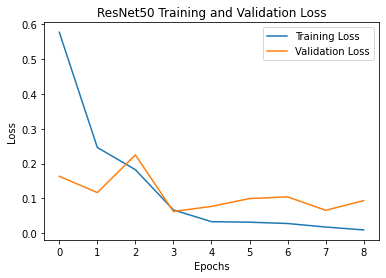

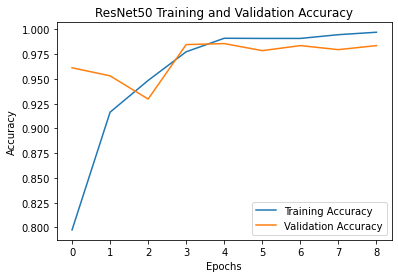

In [8]:
# Plot loss
plt.plot(history_resnet50.history['loss'], label='Training Loss')
plt.plot(history_resnet50.history['val_loss'], label='Validation Loss')
plt.title('ResNet50 Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot accuracy
plt.plot(history_resnet50.history['acc'], label='Training Accuracy')
plt.plot(history_resnet50.history['val_acc'], label='Validation Accuracy')
plt.title('ResNet50 Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [9]:
train_score = model_resnet50.evaluate(train_batches, verbose=1)
test_score = model_resnet50.evaluate(test_batches, verbose=1)

123/123 [==============================] - 6s 50ms/step - loss: 0.0625 - acc: 0.9847


In [10]:
y_true = np.array([])
for i in range(len(test_batches)):
    batch = next(test_batches)
    y_true = np.concatenate([y_true, np.argmax(batch[1], axis=1)])

classname_label = list(test_batches.class_indices.keys())
print(classname_label)

['bacterial_pneumonia', 'covid19', 'normal', 'tuberculosis', 'viral_pneumonia']


Found 982 images belonging to 5 classes.
123/123 [==============================] - 7s 49ms/step

Classification Report:
                      precision    recall  f1-score   support

bacterial_pneumonia    0.99024   0.98544   0.98783       206
            covid19    0.99043   0.98104   0.98571       211
             normal    0.97619   0.98086   0.97852       209
       tuberculosis    1.00000   0.98571   0.99281       140
    viral_pneumonia    0.97273   0.99074   0.98165       216

           accuracy                        0.98473       982
          macro avg    0.98592   0.98476   0.98531       982
       weighted avg    0.98483   0.98473   0.98475       982



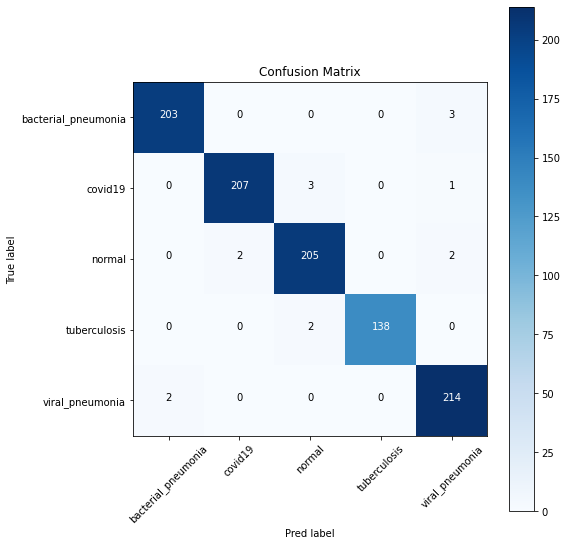

In [11]:
test_all_batches = datagen.flow_from_directory(
    directory=test_path,
    target_size=(image_size, image_size),
    batch_size=val_batch_size,
    shuffle=False,
    class_mode="categorical",
)
true_labels = test_batches.classes
# model.load_weights("VGG16fix.hdf5")

num_test_steps = len(test_all_batches)

predictions = model_resnet50.predict(test_batches, steps=num_test_steps, verbose=1)
predicted_labels = np.argmax(predictions, axis=1)
class_report = classification_report(
    true_labels, predicted_labels, target_names=train_batches.class_indices, digits=5
)
print("\nClassification Report:\n", class_report)

conf_matrix = confusion_matrix(true_labels, predicted_labels)

plt.figure(figsize=(8, 8))
plt.imshow(conf_matrix, interpolation="nearest", cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.colorbar()
tick_marks = np.arange(len(classname_label))
plt.xticks(tick_marks, classname_label, rotation=45)
plt.yticks(tick_marks, classname_label)
thresh = conf_matrix.max() / 2.0
for i, j in itertools.product(range(conf_matrix.shape[0]), range(conf_matrix.shape[1])):
    plt.text(
        j,
        i,
        conf_matrix[i, j],
        horizontalalignment="center",
        color="white" if conf_matrix[i, j] > thresh else "black",
    )

plt.tight_layout()
plt.ylabel("True label")
plt.xlabel("Pred label")
plt.show()

In [12]:
y_true = np.array([])
for i in range(len(train_batches)):
    batch = next(train_batches)
    y_true = np.concatenate([y_true, np.argmax(batch[1], axis=1)])

classname_label = list(train_batches.class_indices.keys())
print(classname_label)

['bacterial_pneumonia', 'covid19', 'normal', 'tuberculosis', 'viral_pneumonia']


Found 6080 images belonging to 5 classes.
380/380 [==============================] - 31s 80ms/step

Training Classification Report:
                      precision    recall  f1-score   support

bacterial_pneumonia    0.99918   0.99918   0.99918      1220
            covid19    0.99598   0.99678   0.99638      1243
             normal    0.99757   0.99595   0.99676      1235
       tuberculosis    0.99915   1.00000   0.99957      1170
    viral_pneumonia    0.99917   0.99917   0.99917      1212

           accuracy                        0.99819      6080
          macro avg    0.99821   0.99822   0.99821      6080
       weighted avg    0.99819   0.99819   0.99819      6080



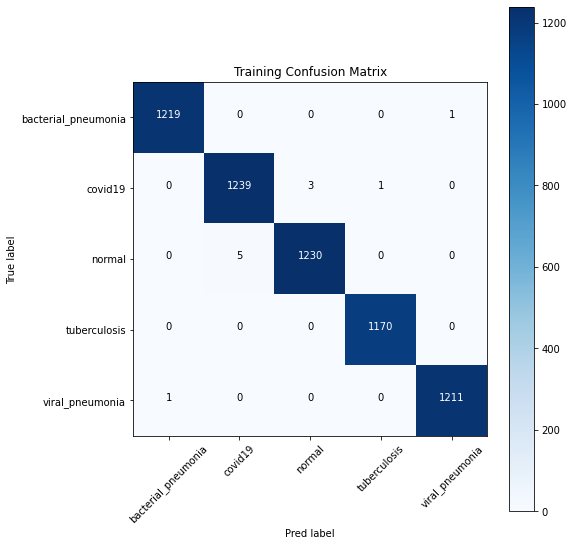

In [13]:
train_all_batches = datagen.flow_from_directory(
    directory=train_path,
    target_size=(image_size, image_size),
    batch_size=batch_size,
    shuffle=False,
    class_mode="categorical",
)

num_train_steps = len(train_all_batches)

train_predictions = model_resnet50.predict(train_all_batches, steps=num_train_steps, verbose=1)
train_predicted_labels = np.argmax(train_predictions, axis=1)
train_true_labels = train_all_batches.classes

train_class_report = classification_report(
    train_true_labels,
    train_predicted_labels,
    target_names=train_all_batches.class_indices,
    digits=5,
)
print("\nTraining Classification Report:\n", train_class_report)

train_conf_matrix = confusion_matrix(train_true_labels, train_predicted_labels)

# Plot
plt.figure(figsize=(8, 8))
plt.imshow(train_conf_matrix, interpolation="nearest", cmap=plt.cm.Blues)
plt.title("Training Confusion Matrix")
plt.colorbar()

tick_marks = np.arange(len(classname_label))
plt.xticks(tick_marks, classname_label, rotation=45)
plt.yticks(tick_marks, classname_label)

thresh = train_conf_matrix.max() / 2.0
for i, j in itertools.product(
    range(train_conf_matrix.shape[0]), range(train_conf_matrix.shape[1])
):
    plt.text(
        j,
        i,
        train_conf_matrix[i, j],
        horizontalalignment="center",
        color="white" if train_conf_matrix[i, j] > thresh else "black",
    )

plt.tight_layout()
plt.ylabel("True label")
plt.xlabel("Pred label")
plt.show()

## VGG19

In [14]:
datagen = ImageDataGenerator(preprocessing_function=tf.keras.applications.vgg19.preprocess_input)

train_batches = datagen.flow_from_directory(train_path,
                                            target_size=(image_size,image_size),
                                            batch_size=batch_size,shuffle=True)

test_batches = datagen.flow_from_directory(test_path,
                                            target_size=(image_size,image_size),
                                            batch_size=val_batch_size,shuffle=False)

Found 6080 images belonging to 5 classes.
Found 982 images belonging to 5 classes.


In [15]:
base_model_vgg19 = tf.keras.applications.VGG19(
    include_top=False, weights="imagenet", input_shape=(image_size, image_size, 3)
)

for layer in base_model_vgg19.layers:
    layer.trainable = True

80150528/80134624 [==============================] - 0s 0us/step


In [16]:
model_vgg19 = Sequential()
model_vgg19.add(base_model_vgg19)
model_vgg19.add(Flatten())
model_vgg19.add(Dense(100, activation='relu'))
model_vgg19.add(Dropout(0.2))
model_vgg19.add(Dense(100, activation='relu'))
model_vgg19.add(Dropout(0.2))
model_vgg19.add(Dense(5, activation="softmax"))

model_vgg19.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg19 (Functional)           (None, 7, 7, 512)         20024384  
_________________________________________________________________
flatten_1 (Flatten)          (None, 25088)             0         
_________________________________________________________________
dense_3 (Dense)              (None, 100)               2508900   
_________________________________________________________________
dropout_2 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 100)               10100     
_________________________________________________________________
dropout_3 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 5)                

In [17]:
model_vgg19.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['acc'])
history_vgg19 = model_vgg19.fit(train_batches, 
                                validation_data=test_batches, 
                                epochs=30, 
                                verbose=1, 
                                callbacks=[early_stopping, 
                                           reduce_lr])

Epoch 1/30
380/380 [==============================] - 119s 294ms/step - loss: 1.0321 - acc: 0.5890 - val_loss: 0.4134 - val_acc: 0.8320
Epoch 2/30
380/380 [==============================] - 110s 288ms/step - loss: 0.4322 - acc: 0.8426 - val_loss: 0.1851 - val_acc: 0.9409
Epoch 3/30
380/380 [==============================] - 111s 293ms/step - loss: 0.2689 - acc: 0.9018 - val_loss: 0.1294 - val_acc: 0.9562
Epoch 4/30
380/380 [==============================] - 112s 294ms/step - loss: 0.2060 - acc: 0.9283 - val_loss: 0.1368 - val_acc: 0.9511
Epoch 5/30
380/380 [==============================] - 112s 294ms/step - loss: 0.1553 - acc: 0.9457 - val_loss: 0.1092 - val_acc: 0.9593
Epoch 6/30
380/380 [==============================] - 112s 294ms/step - loss: 0.1198 - acc: 0.9584 - val_loss: 0.1634 - val_acc: 0.9542
Epoch 7/30
380/380 [==============================] - 111s 293ms/step - loss: 0.0973 - acc: 0.9673 - val_loss: 0.1128 - val_acc: 0.9623
Epoch 8/30
380/380 [============================

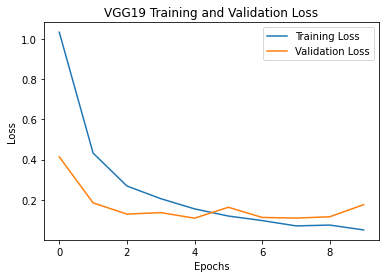

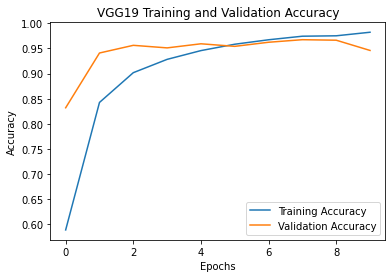

In [18]:
# Plot loss
plt.plot(history_vgg19.history['loss'], label='Training Loss')
plt.plot(history_vgg19.history['val_loss'], label='Validation Loss')
plt.title('VGG19 Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot accuracy
plt.plot(history_vgg19.history['acc'], label='Training Accuracy')
plt.plot(history_vgg19.history['val_acc'], label='Validation Accuracy')
plt.title('VGG19 Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [19]:
train_score = model_vgg19.evaluate(train_batches, verbose=1)
test_score = model_vgg19.evaluate(test_batches, verbose=1)

123/123 [==============================] - 9s 69ms/step - loss: 0.1092 - acc: 0.9593


In [20]:
y_true = np.array([])
for i in range(len(test_batches)):
    batch = next(test_batches)
    y_true = np.concatenate([y_true, np.argmax(batch[1], axis=1)])

classname_label = list(test_batches.class_indices.keys())
print(classname_label)

['bacterial_pneumonia', 'covid19', 'normal', 'tuberculosis', 'viral_pneumonia']


Found 982 images belonging to 5 classes.
123/123 [==============================] - 8s 67ms/step

Classification Report VGG19:
                      precision    recall  f1-score   support

bacterial_pneumonia    0.96585   0.96117   0.96350       206
            covid19    0.97525   0.93365   0.95400       211
             normal    0.93981   0.97129   0.95529       209
       tuberculosis    0.97857   0.97857   0.97857       140
    viral_pneumonia    0.94521   0.95833   0.95172       216

           accuracy                        0.95927       982
          macro avg    0.96094   0.96060   0.96062       982
       weighted avg    0.95960   0.95927   0.95927       982



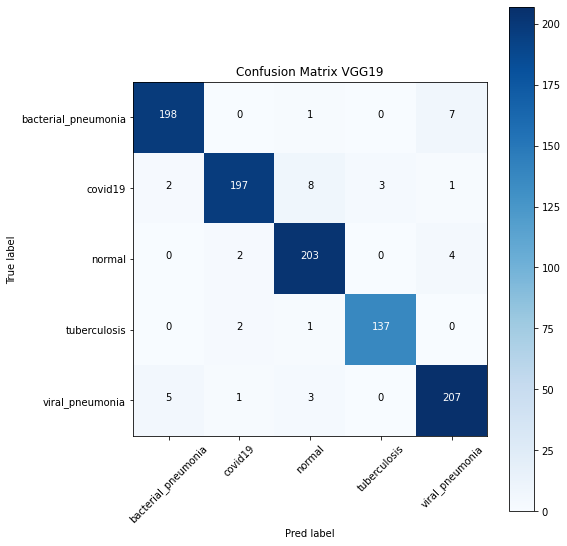

In [21]:
test_all_batches = datagen.flow_from_directory(
    directory=test_path,
    target_size=(image_size, image_size),
    batch_size=val_batch_size,
    shuffle=False,
    class_mode="categorical",
)
true_labels = test_batches.classes
# model.load_weights("VGG16fix.hdf5")

num_test_steps = len(test_all_batches)

predictions = model_vgg19.predict(test_batches, steps=num_test_steps, verbose=1)
predicted_labels = np.argmax(predictions, axis=1)
class_report = classification_report(
    true_labels, predicted_labels, target_names=train_batches.class_indices, digits=5
)
print("\nClassification Report VGG19:\n", class_report)

conf_matrix = confusion_matrix(true_labels, predicted_labels)

plt.figure(figsize=(8, 8))
plt.imshow(conf_matrix, interpolation="nearest", cmap=plt.cm.Blues)
plt.title("Confusion Matrix VGG19")
plt.colorbar()
tick_marks = np.arange(len(classname_label))
plt.xticks(tick_marks, classname_label, rotation=45)
plt.yticks(tick_marks, classname_label)
thresh = conf_matrix.max() / 2.0
for i, j in itertools.product(range(conf_matrix.shape[0]), range(conf_matrix.shape[1])):
    plt.text(
        j,
        i,
        conf_matrix[i, j],
        horizontalalignment="center",
        color="white" if conf_matrix[i, j] > thresh else "black",
    )

plt.tight_layout()
plt.ylabel("True label")
plt.xlabel("Pred label")
plt.show()

In [22]:
y_true = np.array([])
for i in range(len(train_batches)):
    batch = next(train_batches)
    y_true = np.concatenate([y_true, np.argmax(batch[1], axis=1)])

classname_label = list(train_batches.class_indices.keys())
print(classname_label)

['bacterial_pneumonia', 'covid19', 'normal', 'tuberculosis', 'viral_pneumonia']


Found 6080 images belonging to 5 classes.
380/380 [==============================] - 38s 100ms/step

Training Classification Report VGG19:
                      precision    recall  f1-score   support

bacterial_pneumonia    0.98435   0.97951   0.98192      1220
            covid19    0.99505   0.97023   0.98248      1243
             normal    0.97280   0.98462   0.97867      1235
       tuberculosis    0.98235   0.99915   0.99068      1170
    viral_pneumonia    0.97694   0.97855   0.97774      1212

           accuracy                        0.98224      6080
          macro avg    0.98230   0.98241   0.98230      6080
       weighted avg    0.98233   0.98224   0.98223      6080



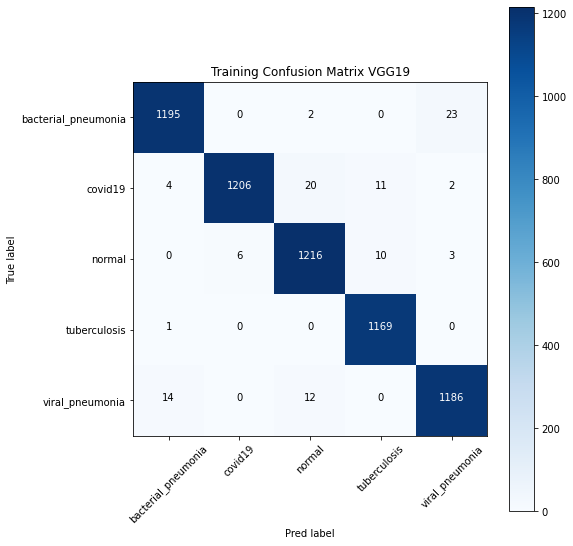

In [23]:
train_all_batches = datagen.flow_from_directory(
    directory=train_path,
    target_size=(image_size, image_size),
    batch_size=batch_size,
    shuffle=False,
    class_mode="categorical",
)

num_train_steps = len(train_all_batches)

train_predictions = model_vgg19.predict(train_all_batches, steps=num_train_steps, verbose=1)
train_predicted_labels = np.argmax(train_predictions, axis=1)
train_true_labels = train_all_batches.classes

train_class_report = classification_report(
    train_true_labels,
    train_predicted_labels,
    target_names=train_all_batches.class_indices,
    digits=5,
)
print("\nTraining Classification Report VGG19:\n", train_class_report)

train_conf_matrix = confusion_matrix(train_true_labels, train_predicted_labels)

# Plot
plt.figure(figsize=(8, 8))
plt.imshow(train_conf_matrix, interpolation="nearest", cmap=plt.cm.Blues)
plt.title("Training Confusion Matrix VGG19")
plt.colorbar()

tick_marks = np.arange(len(classname_label))
plt.xticks(tick_marks, classname_label, rotation=45)
plt.yticks(tick_marks, classname_label)

thresh = train_conf_matrix.max() / 2.0
for i, j in itertools.product(
    range(train_conf_matrix.shape[0]), range(train_conf_matrix.shape[1])
):
    plt.text(
        j,
        i,
        train_conf_matrix[i, j],
        horizontalalignment="center",
        color="white" if train_conf_matrix[i, j] > thresh else "black",
    )

plt.tight_layout()
plt.ylabel("True label")
plt.xlabel("Pred label")
plt.show()

## InceptionV3

In [24]:
datagen = ImageDataGenerator(preprocessing_function=tf.keras.applications.inception_v3.preprocess_input)

train_batches = datagen.flow_from_directory(train_path,
                                            target_size=(image_size,image_size),
                                            batch_size=batch_size,shuffle=True)

test_batches = datagen.flow_from_directory(test_path,
                                            target_size=(image_size,image_size),
                                            batch_size=val_batch_size,shuffle=False)

Found 6080 images belonging to 5 classes.
Found 982 images belonging to 5 classes.


In [25]:
base_model_inceptionv3 = tf.keras.applications.InceptionV3(
    include_top=False, weights="imagenet", input_shape=(image_size, image_size, 3)
)

for layer in base_model_inceptionv3.layers:
    layer.trainable = True

87924736/87910968 [==============================] - 1s 0us/step


In [26]:
model_inceptionv3 = Sequential()
model_inceptionv3.add(base_model_inceptionv3)
model_inceptionv3.add(Flatten())
model_inceptionv3.add(Dense(100, activation='relu'))
model_inceptionv3.add(Dropout(0.2))
model_inceptionv3.add(Dense(100, activation='relu'))
model_inceptionv3.add(Dropout(0.2))
model_inceptionv3.add(Dense(5, activation="softmax"))

model_inceptionv3.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_v3 (Functional)    (None, 5, 5, 2048)        21802784  
_________________________________________________________________
flatten_2 (Flatten)          (None, 51200)             0         
_________________________________________________________________
dense_6 (Dense)              (None, 100)               5120100   
_________________________________________________________________
dropout_4 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_7 (Dense)              (None, 100)               10100     
_________________________________________________________________
dropout_5 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_8 (Dense)              (None, 5)                

In [27]:
model_inceptionv3.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['acc'])
history_inceptionv3 = model_inceptionv3.fit(train_batches, 
                                            validation_data=test_batches, 
                                            epochs=30, 
                                            verbose=1, 
                                            callbacks=[early_stopping, 
                                                       reduce_lr])

Epoch 1/30
380/380 [==============================] - 69s 158ms/step - loss: 0.8832 - acc: 0.6375 - val_loss: 0.4516 - val_acc: 0.8289
Epoch 2/30
380/380 [==============================] - 58s 152ms/step - loss: 0.5014 - acc: 0.8104 - val_loss: 0.3112 - val_acc: 0.8829
Epoch 3/30
380/380 [==============================] - 58s 153ms/step - loss: 0.3614 - acc: 0.8660 - val_loss: 0.2737 - val_acc: 0.8992
Epoch 4/30
380/380 [==============================] - 58s 152ms/step - loss: 0.2723 - acc: 0.9021 - val_loss: 0.2566 - val_acc: 0.9094
Epoch 5/30
380/380 [==============================] - 58s 152ms/step - loss: 0.2438 - acc: 0.9100 - val_loss: 0.2302 - val_acc: 0.9145
Epoch 6/30
380/380 [==============================] - 58s 152ms/step - loss: 0.1797 - acc: 0.9387 - val_loss: 0.2122 - val_acc: 0.9236
Epoch 7/30
380/380 [==============================] - 58s 153ms/step - loss: 0.1369 - acc: 0.9503 - val_loss: 0.2019 - val_acc: 0.9216
Epoch 8/30
380/380 [==============================] - 5

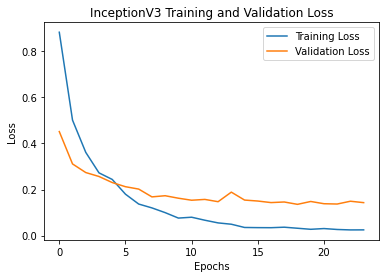

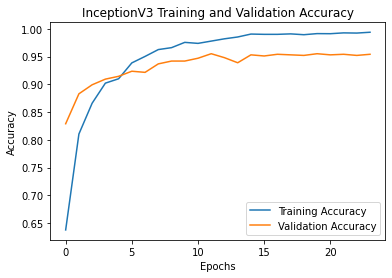

In [28]:
# Plot loss
plt.plot(history_inceptionv3.history['loss'], label='Training Loss')
plt.plot(history_inceptionv3.history['val_loss'], label='Validation Loss')
plt.title('InceptionV3 Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot accuracy
plt.plot(history_inceptionv3.history['acc'], label='Training Accuracy')
plt.plot(history_inceptionv3.history['val_acc'], label='Validation Accuracy')
plt.title('InceptionV3 Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [29]:
train_score = model_inceptionv3.evaluate(train_batches, verbose=1)
test_score = model_inceptionv3.evaluate(test_batches, verbose=1)

123/123 [==============================] - 6s 48ms/step - loss: 0.1356 - acc: 0.9521


In [30]:
y_true = np.array([])
for i in range(len(test_batches)):
    batch = next(test_batches)
    y_true = np.concatenate([y_true, np.argmax(batch[1], axis=1)])

classname_label = list(test_batches.class_indices.keys())
print(classname_label)

['bacterial_pneumonia', 'covid19', 'normal', 'tuberculosis', 'viral_pneumonia']


Found 982 images belonging to 5 classes.
123/123 [==============================] - 7s 46ms/step

Classification Report InceptionV3 :
                      precision    recall  f1-score   support

bacterial_pneumonia    0.96078   0.95146   0.95610       206
            covid19    0.94393   0.95735   0.95059       211
             normal    0.96059   0.93301   0.94660       209
       tuberculosis    0.95775   0.97143   0.96454       140
    viral_pneumonia    0.94064   0.95370   0.94713       216

           accuracy                        0.95214       982
          macro avg    0.95274   0.95339   0.95299       982
       weighted avg    0.95226   0.95214   0.95212       982



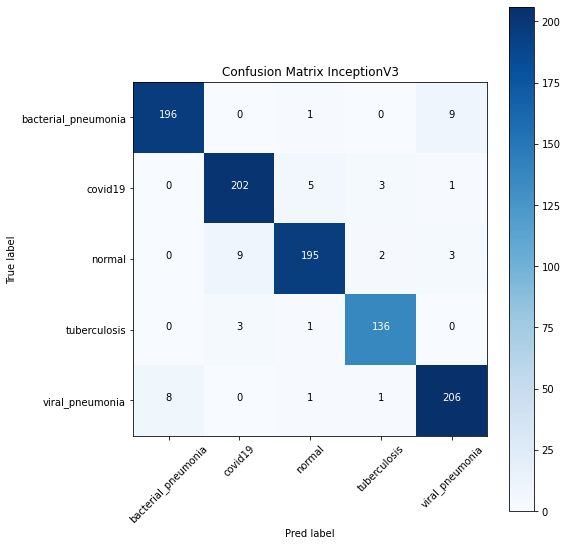

In [31]:
test_all_batches = datagen.flow_from_directory(
    directory=test_path,
    target_size=(image_size, image_size),
    batch_size=val_batch_size,
    shuffle=False,
    class_mode="categorical",
)
true_labels = test_batches.classes
# model.load_weights("VGG16fix.hdf5")

num_test_steps = len(test_all_batches)

predictions = model_inceptionv3.predict(test_batches, steps=num_test_steps, verbose=1)
predicted_labels = np.argmax(predictions, axis=1)
class_report = classification_report(
    true_labels, predicted_labels, target_names=train_batches.class_indices, digits=5
)
print("\nClassification Report InceptionV3 :\n", class_report)

conf_matrix = confusion_matrix(true_labels, predicted_labels)

plt.figure(figsize=(8, 8))
plt.imshow(conf_matrix, interpolation="nearest", cmap=plt.cm.Blues)
plt.title("Confusion Matrix InceptionV3")
plt.colorbar()
tick_marks = np.arange(len(classname_label))
plt.xticks(tick_marks, classname_label, rotation=45)
plt.yticks(tick_marks, classname_label)
thresh = conf_matrix.max() / 2.0
for i, j in itertools.product(range(conf_matrix.shape[0]), range(conf_matrix.shape[1])):
    plt.text(
        j,
        i,
        conf_matrix[i, j],
        horizontalalignment="center",
        color="white" if conf_matrix[i, j] > thresh else "black",
    )

plt.tight_layout()
plt.ylabel("True label")
plt.xlabel("Pred label")
plt.show()

In [32]:
y_true = np.array([])
for i in range(len(train_batches)):
    batch = next(train_batches)
    y_true = np.concatenate([y_true, np.argmax(batch[1], axis=1)])

classname_label = list(train_batches.class_indices.keys())
print(classname_label)

['bacterial_pneumonia', 'covid19', 'normal', 'tuberculosis', 'viral_pneumonia']


Found 6080 images belonging to 5 classes.
380/380 [==============================] - 29s 76ms/step

Training Classification Report InceptionV3 :
                      precision    recall  f1-score   support

bacterial_pneumonia    1.00000   1.00000   1.00000      1220
            covid19    1.00000   0.99920   0.99960      1243
             normal    1.00000   1.00000   1.00000      1235
       tuberculosis    0.99915   1.00000   0.99957      1170
    viral_pneumonia    1.00000   1.00000   1.00000      1212

           accuracy                        0.99984      6080
          macro avg    0.99983   0.99984   0.99983      6080
       weighted avg    0.99984   0.99984   0.99984      6080



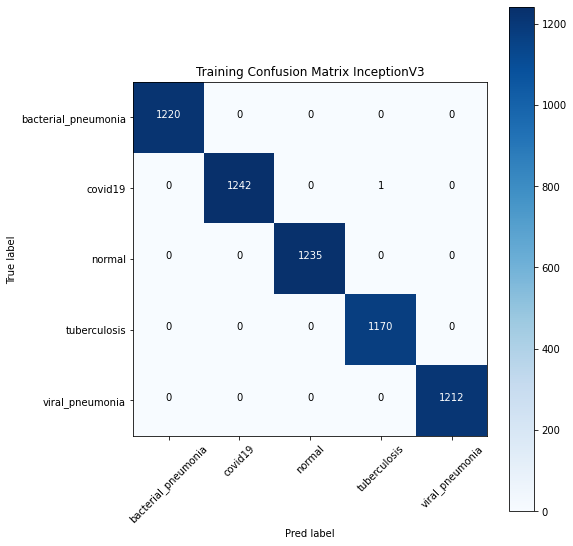

In [33]:
train_all_batches = datagen.flow_from_directory(
    directory=train_path,
    target_size=(image_size, image_size),
    batch_size=batch_size,
    shuffle=False,
    class_mode="categorical",
)

num_train_steps = len(train_all_batches)

train_predictions = model_inceptionv3.predict(train_all_batches, steps=num_train_steps, verbose=1)
train_predicted_labels = np.argmax(train_predictions, axis=1)
train_true_labels = train_all_batches.classes

train_class_report = classification_report(
    train_true_labels,
    train_predicted_labels,
    target_names=train_all_batches.class_indices,
    digits=5,
)
print("\nTraining Classification Report InceptionV3 :\n", train_class_report)

train_conf_matrix = confusion_matrix(train_true_labels, train_predicted_labels)

# Plot
plt.figure(figsize=(8, 8))
plt.imshow(train_conf_matrix, interpolation="nearest", cmap=plt.cm.Blues)
plt.title("Training Confusion Matrix InceptionV3")
plt.colorbar()

tick_marks = np.arange(len(classname_label))
plt.xticks(tick_marks, classname_label, rotation=45)
plt.yticks(tick_marks, classname_label)

thresh = train_conf_matrix.max() / 2.0
for i, j in itertools.product(
    range(train_conf_matrix.shape[0]), range(train_conf_matrix.shape[1])
):
    plt.text(
        j,
        i,
        train_conf_matrix[i, j],
        horizontalalignment="center",
        color="white" if train_conf_matrix[i, j] > thresh else "black",
    )

plt.tight_layout()
plt.ylabel("True label")
plt.xlabel("Pred label")
plt.show()